https://mc.ai/a-beginners-guide-to-build-stacked-autoencoder-and-tying-weights-with-it/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
#Loading the MNIST data
(X_train_orig, _), (X_test, _) = mnist.load_data()
all_data = np.concatenate((X_train_orig, X_test))
all_data.shape

(70000, 28, 28)

In [3]:
# Normalizing the RGB codes by dividing it to the max RGB value.
max_value = float(X_train_orig.max())
X_Train = X_train_orig.astype(np.float32) / max_value
X_Test = X_test.astype(np.float32) / max_value#Train and validation split
X_train, X_valid = X_Train[:-7000], X_Train[-7000:]
X_train.shape, X_valid.shape

((53000, 28, 28), (7000, 28, 28))

In [4]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")#Displays the original images and their reconstructions
    
def show_reconstructions(model, images=X_valid, n_images=10):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

In [5]:
def extract_layers(model):
    new_model = keras.Sequential()
    for layer in model.layers:
        if 'lr2' in layer.name or 'lr3' in layer.name:
            continue
        new_model.add(layer)
    return new_model

In [6]:
#Stacked Autoencoder with functional model
#encoder
inputs = keras.Input(shape=(28,28))
lr_flatten = keras.layers.Flatten()(inputs)
lr1 = keras.layers.Dense(392, activation="selu", name='lr1')(lr_flatten)
lr2 = keras.layers.Dense(196, activation="selu", name='lr2')(lr1)#decoder
lr3 = keras.layers.Dense(392, activation="selu", name='lr3')(lr2)
lr4 = keras.layers.Dense(28 * 28, activation="sigmoid", name='lr4')(lr3)
outputs = keras.layers.Reshape([28, 28])(lr4)
stacked_ae = keras.models.Model(inputs,outputs)
stacked_ae.compile(loss="binary_crossentropy",optimizer=keras.optimizers.SGD(lr=1.5))
stacked_ae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
lr1 (Dense)                  (None, 392)               307720    
_________________________________________________________________
lr2 (Dense)                  (None, 196)               77028     
_________________________________________________________________
lr3 (Dense)                  (None, 392)               77224     
_________________________________________________________________
lr4 (Dense)                  (None, 784)               308112    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)            0     

In [7]:
sub_stacked_ae = extract_layers(model=stacked_ae)

In [8]:
sub_stacked_ae.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
lr1 (Dense)                  (None, 392)               307720    
_________________________________________________________________
lr4 (Dense)                  (None, 784)               308112    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)            0         
Total params: 615,832
Trainable params: 615,832
Non-trainable params: 0
_________________________________________________________________


Train on 53000 samples, validate on 7000 samples
Epoch 1/20
53000/53000 [==============================] - 15s 279us/sample - loss: 0.1334 - val_loss: 0.0985
Epoch 2/20
53000/53000 [==============================] - 14s 273us/sample - loss: 0.0885 - val_loss: 0.0856
Epoch 3/20
53000/53000 [==============================] - 14s 273us/sample - loss: 0.0810 - val_loss: 0.0817
Epoch 4/20
53000/53000 [==============================] - 14s 273us/sample - loss: 0.0775 - val_loss: 0.0801
Epoch 5/20
53000/53000 [==============================] - 14s 272us/sample - loss: 0.0752 - val_loss: 0.0759
Epoch 6/20
53000/53000 [==============================] - 14s 271us/sample - loss: 0.0737 - val_loss: 0.0748
Epoch 7/20
53000/53000 [==============================] - 14s 272us/sample - loss: 0.0726 - val_loss: 0.0739
Epoch 8/20
53000/53000 [==============================] - 14s 272us/sample - loss: 0.0718 - val_loss: 0.0737
Epoch 9/20
53000/53000 [==============================] - 15s 274us/sample - lo

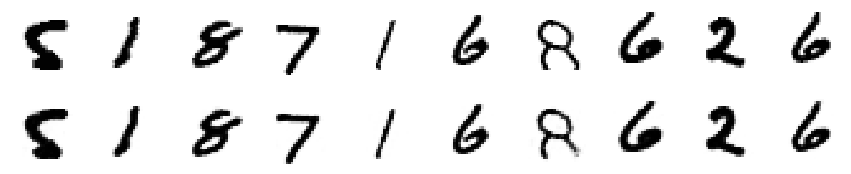

In [9]:
h_stack = stacked_ae.fit(X_train, X_train, epochs=20,validation_data=[X_valid, X_valid])
show_reconstructions(stacked_ae)

In [19]:
lr5 = stacked_ae.layers[5]
lr5.get_weights()

[array([[-0.02942522, -0.09005877, -0.08390021, ..., -0.04141174,
         -0.06699639, -0.08188958],
        [-0.04954068,  0.02548242,  0.04159825, ..., -0.0559487 ,
         -0.02489059, -0.02028304],
        [ 0.02690496, -0.03313914, -0.06805929, ..., -0.01939192,
         -0.052822  , -0.06281637],
        ...,
        [-0.00220598,  0.0025337 , -0.02768977, ...,  0.00427816,
         -0.0800686 ,  0.04319078],
        [ 0.015253  ,  0.07958451,  0.00795365, ..., -0.01861251,
          0.06556694,  0.06202102],
        [-0.0586348 , -0.02380972,  0.0422425 , ...,  0.04795198,
         -0.01874868, -0.01241149]], dtype=float32),
 array([-1.11726951e-02, -1.17455600e-02, -1.40612712e-02, -8.88837874e-03,
        -1.07679460e-02, -9.71594825e-03, -1.23915542e-02, -1.33915637e-02,
        -7.68999616e-03, -1.34289591e-02, -1.09398142e-02, -9.10506025e-03,
        -1.00542540e-02, -1.06424363e-02, -1.14578456e-02, -1.15484549e-02,
        -8.39748699e-03, -1.33021036e-02, -1.34741329e

In [18]:
lr1_sub = sub_stacked_ae.layers[2]
print(lr1_sub.name)
lr1_sub.get_weights()

lr4


[array([[-0.02942522, -0.09005877, -0.08390021, ..., -0.04141174,
         -0.06699639, -0.08188958],
        [-0.04954068,  0.02548242,  0.04159825, ..., -0.0559487 ,
         -0.02489059, -0.02028304],
        [ 0.02690496, -0.03313914, -0.06805929, ..., -0.01939192,
         -0.052822  , -0.06281637],
        ...,
        [-0.00220598,  0.0025337 , -0.02768977, ...,  0.00427816,
         -0.0800686 ,  0.04319078],
        [ 0.015253  ,  0.07958451,  0.00795365, ..., -0.01861251,
          0.06556694,  0.06202102],
        [-0.0586348 , -0.02380972,  0.0422425 , ...,  0.04795198,
         -0.01874868, -0.01241149]], dtype=float32),
 array([-1.11726951e-02, -1.17455600e-02, -1.40612712e-02, -8.88837874e-03,
        -1.07679460e-02, -9.71594825e-03, -1.23915542e-02, -1.33915637e-02,
        -7.68999616e-03, -1.34289591e-02, -1.09398142e-02, -9.10506025e-03,
        -1.00542540e-02, -1.06424363e-02, -1.14578456e-02, -1.15484549e-02,
        -8.39748699e-03, -1.33021036e-02, -1.34741329e

# Using Dense Transpose

In [11]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
        
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias", initializer="zeros",shape=[self.dense.input_shape[-1]])
        super().build(batch_input_shape)
        
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [12]:
dense_1 = keras.layers.Dense(392, activation="selu")
dense_2 = keras.layers.Dense(196, activation="selu")#tied_encoder

inputs = keras.Input(shape=(28,28))
l_flatten = keras.layers.Flatten()(inputs)
l_en1 = dense_1(l_flatten)
l_en2 = dense_2(l_en1)#tied_decoder
l_dc1 = DenseTranspose(dense_2, activation="selu")(l_en2)
l_dc2 = DenseTranspose(dense_1, activation="sigmoid")(l_dc1)
outputs = keras.layers.Reshape([28, 28])(l_dc2)

tied_ae = keras.models.Model(inputs, outputs)
tied_ae.compile(loss="binary_crossentropy",optimizer=keras.optimizers.SGD(lr=1.5))
tied_ae.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 392)               307720    
_________________________________________________________________
dense_7 (Dense)              (None, 196)               77028     
_________________________________________________________________
dense_transpose_2 (DenseTran (None, 392)               77420     
_________________________________________________________________
dense_transpose_3 (DenseTran (None, 784)               308504    
_________________________________________________________________
reshape_2 (Reshape)          (None, 28, 28)            0   

Train on 53000 samples, validate on 7000 samples
Epoch 1/10
53000/53000 [==============================] - 16s 300us/sample - loss: 0.1087 - val_loss: 0.0852
Epoch 2/10
53000/53000 [==============================] - 15s 292us/sample - loss: 0.0779 - val_loss: 0.0775
Epoch 3/10
53000/53000 [==============================] - 15s 289us/sample - loss: 0.0738 - val_loss: 0.0749
Epoch 4/10
53000/53000 [==============================] - 15s 291us/sample - loss: 0.0718 - val_loss: 0.0726
Epoch 5/10
53000/53000 [==============================] - 15s 290us/sample - loss: 0.0706 - val_loss: 0.0721
Epoch 6/10
53000/53000 [==============================] - 16s 293us/sample - loss: 0.0698 - val_loss: 0.0712
Epoch 7/10
53000/53000 [==============================] - 15s 292us/sample - loss: 0.0691 - val_loss: 0.0708
Epoch 8/10
53000/53000 [==============================] - 15s 290us/sample - loss: 0.0686 - val_loss: 0.0699
Epoch 9/10
53000/53000 [==============================] - 15s 291us/sample - lo

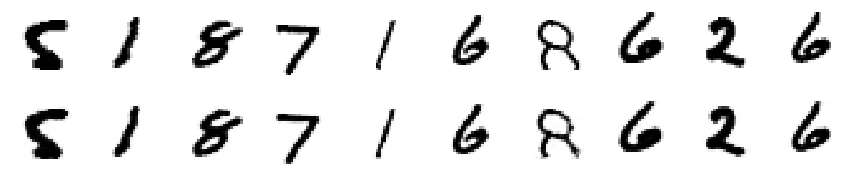

In [9]:
#fit the model 
h_tied = tied_ae.fit(X_train, X_train, epochs=10,validation_data=[X_valid, X_valid])

# reconstruct the image
show_reconstructions(tied_ae)

In [10]:
tied_ae.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 392)               307720    
_________________________________________________________________
dense_5 (Dense)              (None, 196)               77028     
_________________________________________________________________
dense_transpose (DenseTransp (None, 392)               77420     
_________________________________________________________________
dense_transpose_1 (DenseTran (None, 784)               308504    
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28)            0   